# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires 32 bit python, and a 7.1!! version of vensim DSS
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.0](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, MultiprocessingEvaluator, SequentialEvaluator)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density
from ema_workbench.analysis import plotting, plotting_util


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\wesse\anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)
C:\Users\wesse\anaconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 13 cases completed
[MainProcess/INFO] 14 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 21 cases completed
[MainProcess/INFO] 22 cases completed
[MainProcess/INFO] 23 cases completed
[MainProcess/INFO

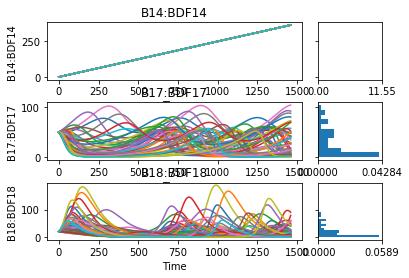

In [2]:
if __name__ == "__main__":
    
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    excelmodel = ExcelModel("predatorPreyExcel", wd = "./model", model_file = 'PredPrey.xlsx')
    excelmodel.uncertainties = [RealParameter('B3', 0.015, 0.035),
                           RealParameter('B4', 0.0005, 0.003),
                           RealParameter('B5', 0.001, 0.004),
                           RealParameter('B6', 0.04, 0.08)
                          ]
    excelmodel.outcomes = [TimeSeriesOutcome('B14:BDF14', variable_name='TIME'),
                           TimeSeriesOutcome('B17:BDF17'),
                           TimeSeriesOutcome('B18:BDF18')
                          ]    
    excelmodel.default_sheet = "Sheet1"

    with MultiprocessingEvaluator(excelmodel) as evaluator:
        results = perform_experiments(excelmodel, 50, reporting_interval = 1, evaluator = evaluator)
    experiments, outcomes = results
    maxExcel = np.max(outcomes['B17:BDF17'])

    outcomes_plot = {key:outcomes[key][:,0,:] for key in outcomes.keys()}

    plotting.lines(experiments, outcomes_plot,  density=plotting_util.Density.HIST)
    plt.show()

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 13 cases completed
[MainProcess/INFO] 14 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 21 cases completed
[MainProcess/INFO] 22 cases completed
[MainProcess/INFO] 23 cases completed
[MainProcess/INFO

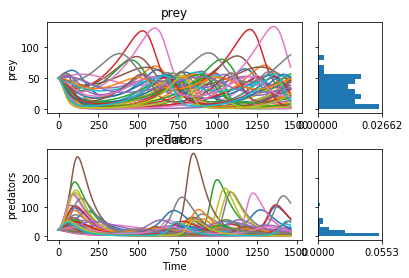

In [3]:
if __name__ == "__main__":
    
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    netlogomodel = NetLogoModel("predatorPreyExcel", wd = "./model", model_file = 'PredPrey.nlogo')
    netlogomodel.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                           RealParameter('predation_rate', 0.0005, 0.003),
                           RealParameter('predator_efficiency', 0.001, 0.004),
                           RealParameter('predator_loss_rate', 0.04, 0.08)
                          ]
    netlogomodel.outcomes = [TimeSeriesOutcome('prey'),
                           TimeSeriesOutcome('predators')
                          ]
    netlogomodel.run_length = int(1460)
    netlogomodel.replications = 5

    with MultiprocessingEvaluator(netlogomodel) as evaluator:
        results = perform_experiments(netlogomodel, scenarios=50, reporting_interval = 1, evaluator = evaluator)
    experiments, outcomes = results
    maxNetlogo = np.max(outcomes['prey'])
 
    outcomes_plot = {key:outcomes[key][:,0,:] for key in outcomes.keys()}

    plotting.lines(experiments, outcomes_plot,  density=plotting_util.Density.HIST)
    plt.show()

[MainProcess/INFO] performing 50 scenarios * 1 policies * 1 model(s) = 50 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 13 cases completed
[MainProcess/INFO] 14 cases completed
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 17 cases completed
[MainProcess/INFO] 18 cases completed
[MainProcess/INFO] 19 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 21 cases completed
[MainProcess/INFO] 22 cases completed
[MainProcess/INFO] 23 cases comp

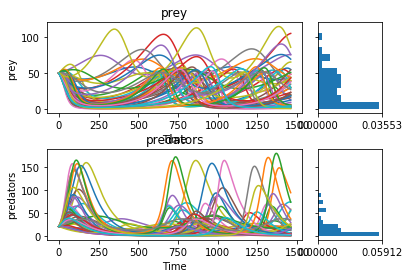

In [4]:
if __name__ == "__main__":
    
    ema_logging.log_to_stderr(level=ema_logging.INFO)
    pysdmodel = PysdModel("predatorPreyExcel", mdl_file = './model/PredPrey.mdl')
    pysdmodel.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                           RealParameter('predation_rate', 0.0005, 0.003),
                           RealParameter('predator_efficiency', 0.001, 0.004),
                           RealParameter('predator_loss_rate', 0.04, 0.08)
                          ]
    pysdmodel.outcomes = [TimeSeriesOutcome('prey'),
                          TimeSeriesOutcome('predators')
                         ]

    with SequentialEvaluator(pysdmodel) as evaluator:
        results = perform_experiments(pysdmodel, scenarios=50, reporting_interval = 1, evaluator = evaluator)
    experiments, outcomes = results
    maxSd = np.max(outcomes['prey'])

    plotting.lines(experiments, outcomes,  density=plotting_util.Density.HIST)
    plt.show()


### Maxima of Prey variable


In [5]:
maxPy = np.max(PredPrey()['prey'])
mydict={'maxPy':maxPy, 'maxExcel':maxExcel, 'maxNetlogo':maxNetlogo, 'maxSd':maxSd}
mydict


{'maxPy': 52.08141426044413,
 'maxExcel': 103.30217392162788,
 'maxNetlogo': 132.98295181674163,
 'maxSd': 114.54496242656583}